In [11]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                             precision_recall_curve, confusion_matrix, average_precision_score)
import xgboost as xgb
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv(r"C:\Users\alefs\OneDrive\Documentos\LAPEI-CIGETS\GitHub\tcp\01_dados\data_mobilidade_v4.csv")

list(df)

['Unnamed: 0',
 'id',
 'id_seq',
 'transicao',
 'V1023',
 'idade',
 'genero',
 'VD3004',
 'V2010',
 'V2005',
 'UF',
 'qtd_pessoas',
 'periodo_ajust',
 'ensino_medio',
 'ensino_superior',
 'raça',
 'posicao_familiar',
 'tempo_desemprego',
 'filhos',
 'regiao',
 'renda_domiciliar',
 'renda_depois']

In [3]:
df_tratado = df.rename(columns={'V1023':'regiao_urbana','VD3004':'escolaridade','V2010':'cor','UF':'uf'})

df_tratado = df_tratado[['transicao','idade','escolaridade', 'genero', 'cor','qtd_pessoas',
                         'periodo_ajust','filhos', 'tempo_desemprego', 'uf',
                        'posicao_familiar', 'renda_domiciliar', 'regiao_urbana']]

bins = [0, 3, 5, 9, 21, float('inf')]
labels = ['Tempo de desemprego: muito baixo', 'Tempo de desemprego: baixo', 
          'Tempo de desemprego: mediano', 'Tempo de desemprego: alto', 'Tempo de desemprego: muito alto']
df_tratado['intervalo_desemprego'] = pd.cut(df_tratado['tempo_desemprego'], bins=bins, labels=labels, right=False)

df_tratado['transicao'] = df_tratado['transicao'].map({'Migrou para TCP': 1, 'Migrou para o setor privado': 0})

df_final = df_tratado.drop(columns = 'tempo_desemprego')

df_final.head(30).style

,transicao,idade,escolaridade,genero,cor,qtd_pessoas,periodo_ajust,filhos,uf,posicao_familiar,renda_domiciliar,regiao_urbana,intervalo_desemprego
0,1,28,Superior completo,Homem,Parda,3.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,750.000000,Capital,Tempo de desemprego: mediano
1,1,33,Médio completo ou equivalente,Homem,Parda,4.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,162.500000,Capital,Tempo de desemprego: muito alto
2,1,24,Médio incompleto ou equivalente,Mulher,Parda,2.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,488.500000,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",Tempo de desemprego: muito alto
3,0,39,Superior completo,Homem,Parda,4.000000,Pré-pandemia,1,Rondônia,Responsável pelo domicílio,378.750000,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",Tempo de desemprego: baixo
4,0,26,Superior completo,Mulher,Parda,3.000000,Pré-pandemia,0,Acre,Não responsável pelo domicílio,418.000000,Capital,Tempo de desemprego: baixo
5,0,49,Fundamental incompleto ou equivalente,Mulher,Parda,3.000000,Pré-pandemia,0,Acre,Responsável pelo domicílio,53.333333,Capital,Tempo de desemprego: mediano
6,0,34,Fundamental completo ou equivalente,Homem,Parda,1.000000,Pré-pandemia,0,Acre,Responsável pelo domicílio,0.000000,Capital,Tempo de desemprego: muito baixo
7,0,42,Sem instrução e menos de 1 ano de estudo,Homem,Branca,3.000000,Pré-pandemia,1,Acre,Não responsável pelo domicílio,318.000000,Capital,Tempo de desemprego: alto
8,0,22,Médio completo ou equivalente,Homem,Parda,6.800000,Pré-pandemia,0,Amazonas,Não responsável pelo domicílio,25.714286,Capital,Tempo de desemprego: alto
9,0,48,Médio completo ou equivalente,Homem,Parda,8.800000,Pré-pandemia,0,Amazonas,Responsável pelo domicílio,408.555556,Capital,Tempo de desemprego: mediano


In [4]:
def dividir(df):
    y = df[['transicao']]
    X = df.drop(columns=['transicao'])

    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=22)

    # Aplicar pré-processamento
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Aplicar balanceamento com SMOTE
    smote = SMOTEENN(random_state=5222)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

    return X_train_balanced, X_test_processed, y_train_balanced, y_test, preprocessor, X_train

In [5]:
x_train, x_test, y_train, y_test, preprocessor, x_train_raw1 = dividir(df_final)

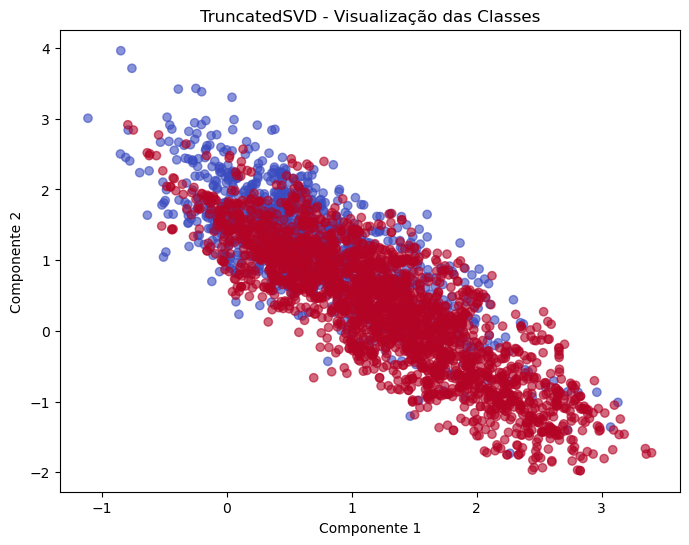

In [12]:
y_train_teste = y_train['transicao'].values
svd = TruncatedSVD(n_components=2, random_state=42)
x_svd = svd.fit_transform(x_train)

plt.figure(figsize=(8,6))
plt.scatter(x_svd[:,0], x_svd[:,1], c=y_train_teste, cmap='coolwarm', alpha=0.6)
plt.title('TruncatedSVD - Visualização das Classes')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

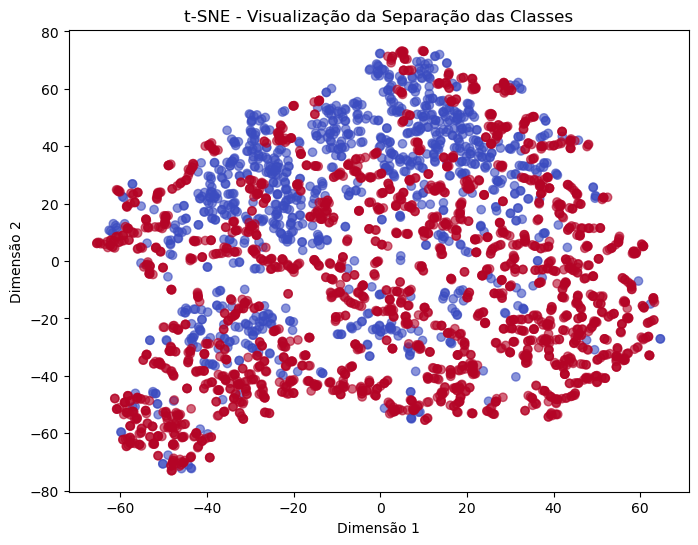

In [16]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='random')
X_tsne = tsne.fit_transform(x_train)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_train_teste, cmap='coolwarm', alpha=0.6)
plt.title('t-SNE - Visualização da Separação das Classes')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.show()

In [6]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# --- Função Objetivo para o Optuna (ATUALIZADA PARA PR AUC) ---
def objective(trial, model_name, x_train, y_train):
    """
    Função objetivo que o Optuna tentará maximizar.
    Usa validação cruzada para avaliar o desempenho de uma dada combinação de hiperparâmetros.
    """
    # A definição dos hiperparâmetros permanece a mesma
    if model_name == 'Logistic Regression':
        C = trial.suggest_float('C', 1e-2, 10, log=True)
        model = LogisticRegression(C=C, random_state=42, solver='liblinear')

    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 15)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        gamma = trial.suggest_float('gamma', 0, 1.0)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, use_label_encoder=False, eval_metric='logloss', random_state=42)

    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        num_leaves = trial.suggest_int('num_leaves', 20, 100)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, random_state=42)

    # Para garantir a reprodutibilidade da validação cruzada
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # **MUDANÇA PRINCIPAL AQUI**
    # A métrica agora é 'average_precision', que corresponde à área sob a curva Precision-Recall.
    score = cross_val_score(model, x_train, y_train, cv=cv_splitter, scoring='average_precision', n_jobs=-1) # <-- MUDANÇA AQUI

    # Retorna a média das pontuações dos folds
    return score.mean()

# --- Função Principal de Treinamento e Avaliação (ATUALIZADA) ---
def treinando_avaliando_optuna(x_train, y_train, x_test, y_test):
    """
    Orquestra a otimização com Optuna e a avaliação final.
    """
    best_models = {}

    for name in models.keys():
        print(f"Otimizando o modelo: {name}")
        func = lambda trial: objective(trial, name, x_train, y_train)
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(func, n_trials=20)
        print(f"Melhores parâmetros para {name}: {study.best_params}\n")

        best_model_class = models[name].__class__
        best_params = study.best_params
        
        # Ajustes especiais para modelos que não aceitam todos os parâmetros no construtor
        if name == 'Logistic Regression':
            best_params['solver'] = 'liblinear'
        
        best_model = best_model_class(**best_params, random_state=42)
        
        if name in ['XGBoost']:
            best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        
        best_model.fit(x_train, y_train)
        best_models[name] = best_model

    # Avaliação no conjunto de teste (RELATÓRIO ATUALIZADO)
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob),
            'PR AUC': average_precision_score(y_test, y_prob) # <-- MÉTRICA ADICIONADA AO RELATÓRIO
        })

    # Converte para DataFrame para melhor visualização
    return results, best_models

In [7]:
results_df, final_models = treinando_avaliando_optuna(x_train, y_train, x_test, y_test)
results_m1_df = pd.DataFrame(results_df)
print(results_m1_df.sort_values(by = 'ROC AUC', ascending = False))

[I 2025-06-24 14:52:18,483] A new study created in memory with name: no-name-46cd03e0-ec9e-4457-85c2-c36d029c7c28


Otimizando o modelo: Logistic Regression


[I 2025-06-24 14:52:20,213] Trial 0 finished with value: 0.9208901188686813 and parameters: {'C': 0.13292918943162169}. Best is trial 0 with value: 0.9208901188686813.
[I 2025-06-24 14:52:21,363] Trial 1 finished with value: 0.9197901687021215 and parameters: {'C': 7.114476009343421}. Best is trial 0 with value: 0.9208901188686813.
[I 2025-06-24 14:52:22,401] Trial 2 finished with value: 0.9196921659638857 and parameters: {'C': 1.5702970884055387}. Best is trial 0 with value: 0.9208901188686813.
[I 2025-06-24 14:52:22,447] Trial 3 finished with value: 0.9202238254368178 and parameters: {'C': 0.6251373574521749}. Best is trial 0 with value: 0.9208901188686813.
[I 2025-06-24 14:52:22,495] Trial 4 finished with value: 0.9178947663171343 and parameters: {'C': 0.02938027938703535}. Best is trial 0 with value: 0.9208901188686813.
[I 2025-06-24 14:52:22,526] Trial 5 finished with value: 0.9178919587473711 and parameters: {'C': 0.029375384576328288}. Best is trial 0 with value: 0.9208901188686

Melhores parâmetros para Logistic Regression: {'C': 0.13560376846665012}

Otimizando o modelo: Decision Tree


[I 2025-06-24 14:52:23,324] Trial 1 finished with value: 0.8759694448586235 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9050907662993979.
[I 2025-06-24 14:52:23,403] Trial 2 finished with value: 0.8474412298258119 and parameters: {'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9050907662993979.
[I 2025-06-24 14:52:23,467] Trial 3 finished with value: 0.9154678195816791 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.9154678195816791.
[I 2025-06-24 14:52:23,576] Trial 4 finished with value: 0.8864941606352614 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9154678195816791.
[I 2025-06-24 14:52:23,636] Trial 5 finished with value: 0.8843416511069119 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 3 wi

Melhores parâmetros para Decision Tree: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 10}

Otimizando o modelo: Random Forest


[I 2025-06-24 14:52:27,965] Trial 0 finished with value: 0.9811250592430051 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9811250592430051.
[I 2025-06-24 14:52:28,795] Trial 1 finished with value: 0.9653888898806112 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9811250592430051.
[I 2025-06-24 14:52:33,685] Trial 2 finished with value: 0.9774755537932931 and parameters: {'n_estimators': 700, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9811250592430051.
[I 2025-06-24 14:52:38,039] Trial 3 finished with value: 0.9738897808541539 and parameters: {'n_estimators': 900, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9811250592430051.
[I 2025-06-24 14:52:41,054] Trial 4 finished with value: 0.9815685220659554 and parameters: {'

Melhores parâmetros para Random Forest: {'n_estimators': 300, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}



[I 2025-06-24 14:53:27,647] A new study created in memory with name: no-name-e191f024-2e75-406b-96fe-3a71090e731d


Otimizando o modelo: XGBoost


[I 2025-06-24 14:53:28,969] Trial 0 finished with value: 0.987713628485141 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265}. Best is trial 0 with value: 0.987713628485141.
[I 2025-06-24 14:53:29,555] Trial 1 finished with value: 0.9868901611763011 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.9699098521619943}. Best is trial 0 with value: 0.987713628485141.
[I 2025-06-24 14:53:31,445] Trial 2 finished with value: 0.9854929438895226 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'gamma': 0.5247564316322378}. Best is trial 0 with value: 0.987713628485141.
[I 2025-06-24 14:53:32,739] Trial 3 finished wit

Melhores parâmetros para XGBoost: {'n_estimators': 800, 'max_depth': 7, 'learning_rate': 0.042985585515884606, 'subsample': 0.7273145000499233, 'colsample_bytree': 0.8655266680983513, 'gamma': 0.0042177914909484904}



[I 2025-06-24 14:54:31,930] A new study created in memory with name: no-name-6bc82fd6-30f2-427c-a1f5-4d59eebf6a51


Otimizando o modelo: LightGBM


[I 2025-06-24 14:54:36,216] Trial 0 finished with value: 0.9879877732731057 and parameters: {'n_estimators': 400, 'learning_rate': 0.2536999076681772, 'num_leaves': 79, 'min_child_samples': 32}. Best is trial 0 with value: 0.9879877732731057.
[I 2025-06-24 14:54:39,171] Trial 1 finished with value: 0.9778361254386236 and parameters: {'n_estimators': 200, 'learning_rate': 0.01699897838270077, 'num_leaves': 24, 'min_child_samples': 44}. Best is trial 0 with value: 0.9879877732731057.
[I 2025-06-24 14:54:43,115] Trial 2 finished with value: 0.9866201339638092 and parameters: {'n_estimators': 700, 'learning_rate': 0.11114989443094977, 'num_leaves': 21, 'min_child_samples': 49}. Best is trial 0 with value: 0.9879877732731057.
[I 2025-06-24 14:54:49,455] Trial 3 finished with value: 0.98791860234001 and parameters: {'n_estimators': 900, 'learning_rate': 0.020589728197687916, 'num_leaves': 34, 'min_child_samples': 13}. Best is trial 0 with value: 0.9879877732731057.
[I 2025-06-24 14:54:53,186

Melhores parâmetros para LightGBM: {'n_estimators': 400, 'learning_rate': 0.28949872259141385, 'num_leaves': 81, 'min_child_samples': 6}

[LightGBM] [Info] Number of positive: 2406, number of negative: 1015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4148
[LightGBM] [Info] Number of data points in the train set: 3421, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703303 -> initscore=0.863077
[LightGBM] [Info] Start training from score 0.863077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [8]:
#Identificando o nome do algoritmo com a melhor ROC AUC
best_model_name = results_m1_df.sort_values(by='PR AUC', ascending=False).iloc[0]['Model']

#Recuperando o algoritmo com base no nome do algoritmo
best_model_m1 = final_models[best_model_name]

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2406, number of negative: 1015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4148
[LightGBM] [Info] Number of data points in the train set: 3421, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703303 -> initscore=0.863077
[LightGBM] [Info] Start training from score 0.863077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

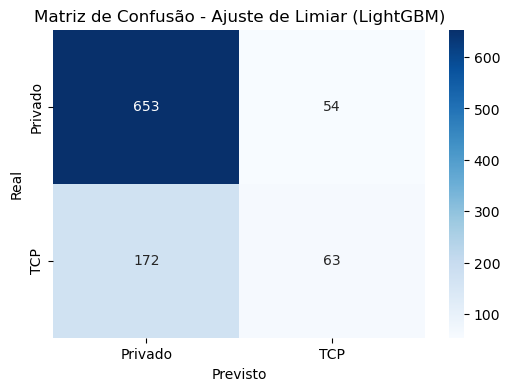

In [9]:
# Treine o modelo
best_model_m1.fit(x_train, y_train)

# Calcular probabilidades e encontrar o melhor limiar baseado no F1 Score
y_prob_train = best_model_m1.predict_proba(x_train)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob_train)

best_threshold, best_f1 = max(((threshold, f1_score(y_train, (y_prob_train >= threshold).astype(int))) for threshold in thresholds), key=lambda x: x[1])

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Ajustar previsões no conjunto de teste
y_pred_adjusted = (best_model_m1.predict_proba(X=x_test)[:, 1] >= best_threshold).astype(int)

# Matriz de Confusão
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Exibição da Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Privado', 'TCP'], yticklabels=['Privado', 'TCP'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [10]:
print("ROC AUC: ", roc_auc_score(y_test, y_pred_adjusted))
print("Precision: ", precision_score(y_test, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test, y_pred_adjusted))
print("Recall: ", recall_score(y_test, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test, y_pred_adjusted))
print('PR AUC', average_precision_score(y_test, y_pred_adjusted))

ROC AUC:  0.5958530199524512
Precision:  0.5384615384615384
Accuracy:  0.7600849256900213
Recall:  0.2680851063829787
F1 Score:  0.35795454545454547
PR AUC 0.3269437523672515


In [30]:
# CORREÇÃO: Use o TreeExplainer e passe o objeto do modelo diretamente
explainer = shap.TreeExplainer(best_model_m1) 

# O cálculo dos valores SHAP agora funciona corretamente
shap_values = explainer.shap_values(x_test)

# Para visualizar a primeira predição
shap.initjs()

C:\Users\alefs\anaconda3\lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


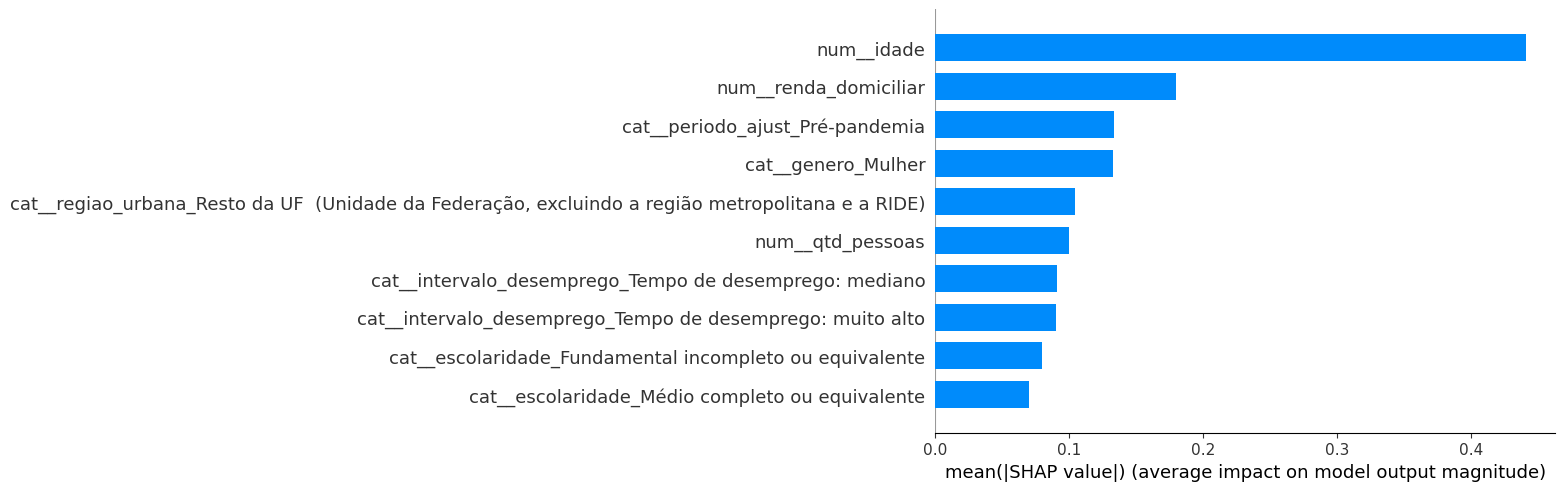

In [31]:
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, features= x_test,
                  feature_names= feature_names,
                  plot_type="bar",
                 max_display = 10)

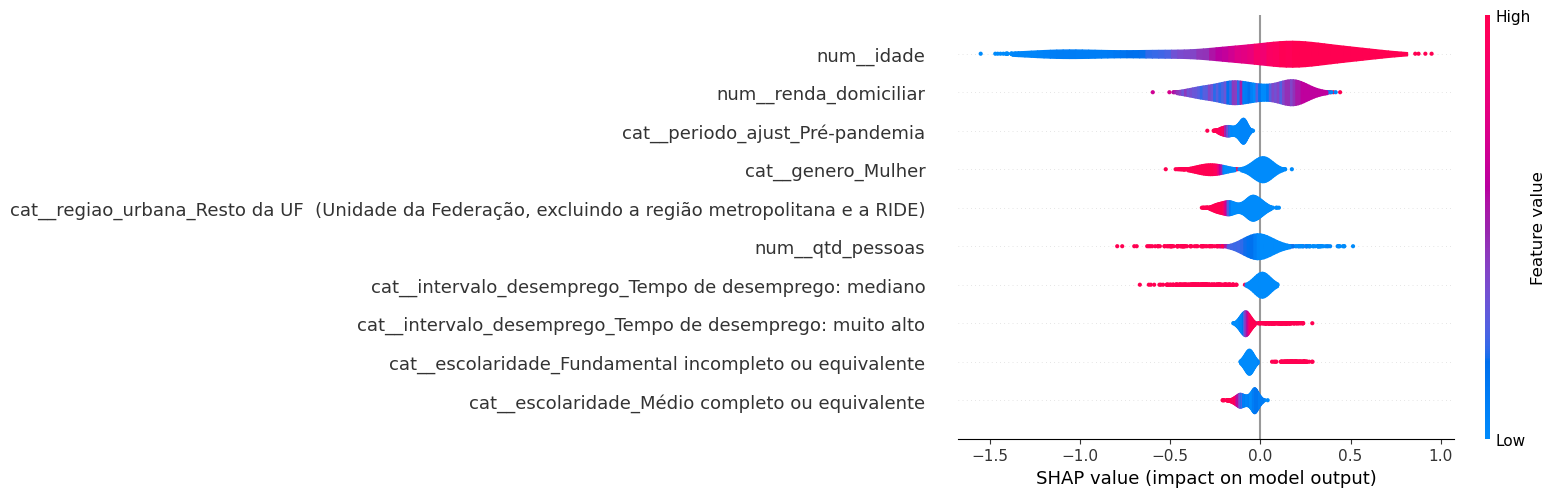

In [32]:
shap.summary_plot(shap_values, 
                  features=x_test.toarray(), # <--- A MUDANÇA PRINCIPAL ESTÁ AQUI
                  feature_names=feature_names,
                  plot_type="violin",
                  max_display=10)